[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


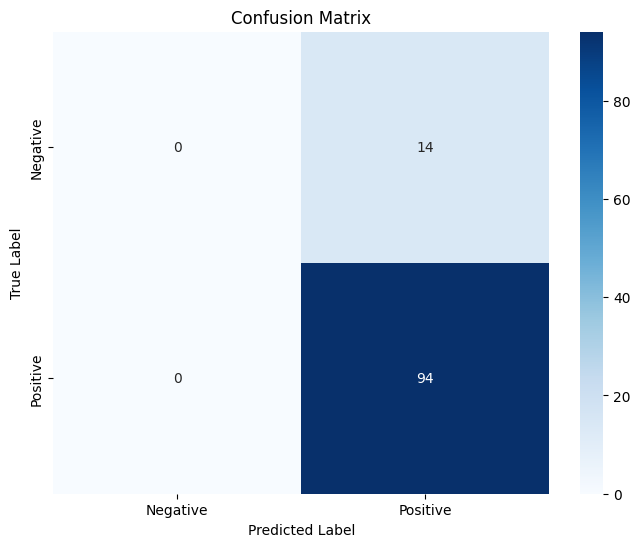

Accuracy: 0.8703703703703703


In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """ Lowercase, remove punctuation, numbers, and stopwords, and apply lemmatization. """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load and preprocess data
data_path = '/content/drive/My Drive/experiment/example_hotel_review.csv'
reviews_df = pd.read_csv(data_path)
reviews_df['Processed_Reviews'] = reviews_df['Positive_Review'].str.cat(reviews_df['Negative_Review'], sep=" ").apply(preprocess_text)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=reviews_df['Processed_Reviews'], vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("/content/drive/My Drive/experiment/word2vec_model.bin")

# Load the Word2Vec model
word2vec_model = Word2Vec.load("/content/drive/My Drive/experiment/word2vec_model.bin")

class SentimentAnalysisModel(nn.Module):
    def __init__(self, word2vec_model):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), mode='mean')
        self.classifier = nn.Linear(word2vec_model.vector_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        output = self.classifier(embedded)
        return self.sigmoid(output)

def generate_input_tensor(texts, word2vec_model):
    indices = [[word2vec_model.wv.key_to_index[word] for word in text if word in word2vec_model.wv] for text in texts]
    indices_tensor = [torch.tensor(x) for x in indices]
    return indices_tensor

sentiment_model = SentimentAnalysisModel(word2vec_model)

def predict_sentiment(texts):
    input_tensors = generate_input_tensor(texts, word2vec_model)
    predictions = []
    for tensor in input_tensors:
        logits = sentiment_model(tensor.unsqueeze(0))  # Add batch dimension
        predictions.append(logits.item())
    return [1 if p >= 0.5 else 0 for p in predictions]

# Example usage
test_texts = reviews_df['Processed_Reviews'].tolist()  # Use token lists directly
test_labels = (reviews_df['Reviewer_Score'] >= 5).astype(int).tolist()
test_predictions = predict_sentiment(test_texts)
accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
